Step 1: Import Libraries & Load Dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Online Retail dataset (UCI dataset CSV)
df = pd.read_excel("Online Retail.xlsx")  # update with actual file path

# Preview
print(df.head())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


Step 2: Data Cleaning

Remove cancelled orders

Remove missing customer IDs

In [ ]:
# Drop missing CustomerID
df = df.dropna(subset=["CustomerID"])

# Remove cancelled transactions (InvoiceNo starting with 'C')
df = df[~df["InvoiceNo"].astype(str).str.startswith('C')]

# Create a new column for Total Amount
df["TotalAmount"] = df["Quantity"] * df["UnitPrice"]

print(df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      397924 non-null  object        
 8   TotalAmount  397924 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB
None


Step 3: Create RFM Table

In [ ]:
# Define reference date (latest date in dataset)
import datetime as dt
ref_date = df["InvoiceDate"].max() + dt.timedelta(days=1)

# Aggregate data for each customer
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (ref_date - x.max()).days,  # Recency
    "InvoiceNo": "nunique",   # Frequency
    "TotalAmount": "sum"      # Monetary
})

# Rename columns
rfm.columns = ["Recency", "Frequency", "Monetary"]

print(rfm.head())


            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1  77183.60
12347.0           2          7   4310.00
12348.0          75          4   1797.24
12349.0          19          1   1757.55
12350.0         310          1    334.40


Step 4: Assign RFM Scores

Use quartiles to score each customer 1–4 (1 = low, 4 = high)

In [ ]:
# R = lower is better (recent purchase)
rfm["R_Score"] = pd.qcut(rfm["Recency"], 4, labels=[4,3,2,1])

# F & M = higher is better
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 4, labels=[1,2,3,4])
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 4, labels=[1,2,3,4])

# Final RFM Score
rfm["RFM_Segment"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)
rfm["RFM_Score"] = rfm[["R_Score","F_Score","M_Score"]].astype(int).sum(axis=1)

print(rfm.head())


            Recency  Frequency  Monetary R_Score F_Score M_Score RFM_Segment  \
CustomerID                                                                     
12346.0         326          1  77183.60       1       1       4         114   
12347.0           2          7   4310.00       4       4       4         444   
12348.0          75          4   1797.24       2       3       4         234   
12349.0          19          1   1757.55       3       1       4         314   
12350.0         310          1    334.40       1       1       2         112   

            RFM_Score  
CustomerID             
12346.0             6  
12347.0            12  
12348.0             9  
12349.0             8  
12350.0             4  


Step 5: Customer Segmentation

In [ ]:

# Simple segmentation rules
def segment_customer(score):
    if score >= 9:
        return "Champions"
    elif score >= 7:
        return "Loyal"
    elif score >= 5:
        return "Potential"
    else:
        return "At Risk"

rfm["Segment"] = rfm["RFM_Score"].apply(segment_customer)

print(rfm["Segment"].value_counts())


Segment
Champions    1680
Potential     989
Loyal         863
At Risk       807
Name: count, dtype: int64



📊 Step 6: Visualization
Distribution of Segments

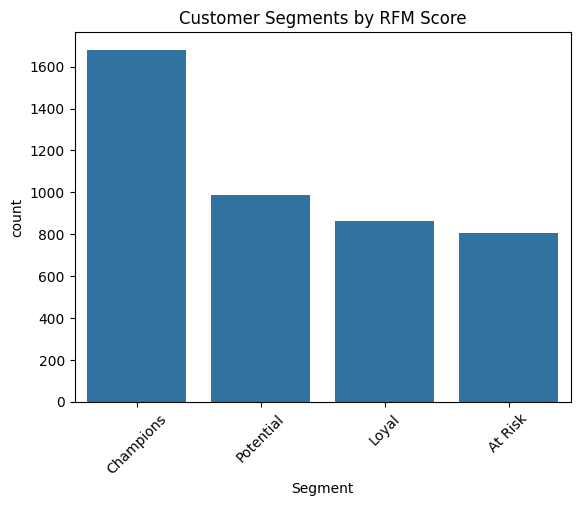

In [ ]:
sns.countplot(x="Segment", data=rfm, order=rfm["Segment"].value_counts().index)
plt.title("Customer Segments by RFM Score")
plt.xticks(rotation=45)
plt.show()


Heatmap of Mean RFM Scores per Segment

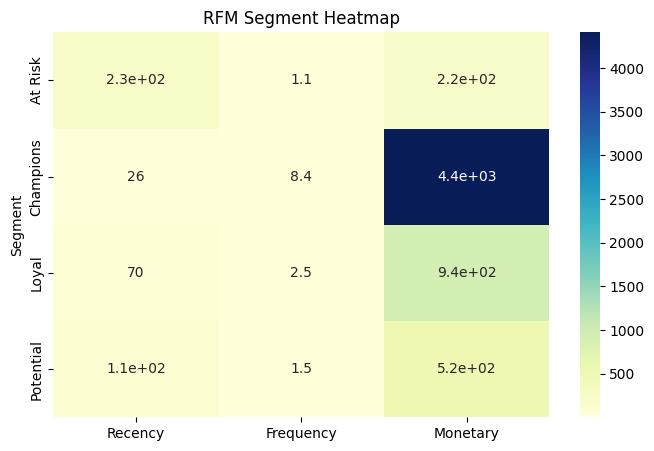

In [ ]:
rfm_grouped = rfm.groupby("Segment")[["Recency","Frequency","Monetary"]].mean().round(1)

plt.figure(figsize=(8,5))
sns.heatmap(rfm_grouped, annot=True, cmap="YlGnBu")
plt.title("RFM Segment Heatmap")
plt.show()


Step 7: Assign Marketing Ideas to Segments


In [9]:
# Define marketing strategy for each segment
marketing_dict = {
    "Champions": "VIP treatment: early access, loyalty rewards, referral bonuses",
    "Loyal": "Personalized recommendations, cross-sell/upsell campaigns, exclusive offers",
    "Potential": "Discounts on next order, onboarding tips, nurture with targeted campaigns",
    "At Risk": "Re-engagement campaigns, reminder emails, win-back discounts"
}

# Map each customer’s segment to a strategy
rfm["Marketing_Strategy"] = rfm["Segment"].map(marketing_dict)

# Preview with sample customers
print(rfm[["Recency", "Frequency", "Monetary", "Segment", "Marketing_Strategy"]].head(10))


            Recency  Frequency  Monetary    Segment  \
CustomerID                                            
12346.0         326          1  77183.60  Potential   
12347.0           2          7   4310.00  Champions   
12348.0          75          4   1797.24  Champions   
12349.0          19          1   1757.55      Loyal   
12350.0         310          1    334.40    At Risk   
12352.0          36          8   2506.04  Champions   
12353.0         204          1     89.00    At Risk   
12354.0         232          1   1079.40  Potential   
12355.0         214          1    459.40    At Risk   
12356.0          23          3   2811.43  Champions   

                                           Marketing_Strategy  
CustomerID                                                     
12346.0     Discounts on next order, onboarding tips, nurt...  
12347.0     VIP treatment: early access, loyalty rewards, ...  
12348.0     VIP treatment: early access, loyalty rewards, ...  
12349.0     Persona